# Advanced Vehicle Detection and Tracking
The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

### Import Dependencies
The necessary packages for this project are imported.

In [1]:
import numpy as np
import pickle, cv2, glob, time
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
% matplotlib inline
print('Import Dependencies - Complete.')

# if True, a classifier is loaded from the saved pickle file
pickle_load = True

Import Dependencies - Complete.


### Define a read image function for consistency
Matplolib's image.imread() method returns a float32 datatype for PNG files and uint8 for JPG files. Thus, in an effort to maintain consistency across various image types, we utilize PIL's Image.open() method to return an uint8 data type array.

In [2]:
def read_image(img_path):
    return np.asarray(Image.open(img_path))

### Retrieve Vehicle and Non-Vehicle Image Files
We retrieve the file names for all vehicle and non-vehicle images. These 64x64 PNG images will comprise of our training data for our support vector machine classifier.

In [3]:
vehicles = glob.glob('./vehicles/**/*.png')
non_vehicles = glob.glob('./non-vehicles/**/*.png')
print('Vehicle count: {}, Non-Vehicle count: {}'.format(len(vehicles),len(non_vehicles)))

Vehicle count: 8792, Non-Vehicle count: 8968


### Balance Training Data Classes
Unbalanced data classes in a training set may result in a biased classifier, thus, we ensure that both classes (vehicle and non-vehicle) have the same number of training examples.

In [4]:
data_limit = min(len(vehicles),len(non_vehicles))
vehicles = vehicles[:data_limit]
non_vehicles = non_vehicles[:data_limit]
print('Vehicle count: {}, Non-Vehicle count: {}'.format(len(vehicles),len(non_vehicles)))

Vehicle count: 8792, Non-Vehicle count: 8792


### Define Histogram of Gradients Feature
We utilize the Histogram of Gradients (HOG) method provided by the skimage package to highlight edge features in our training images.

In [5]:
def hog_feature_extract(img,orient=9,pix_per_cell=8,cell_per_block=2,visualise=False,feature_vector=True):
    if visualise:
        hog_feature,hog_image = hog(img,orientations=orient,pixels_per_cell=(pix_per_cell,pix_per_cell),cells_per_block=(cell_per_block,cell_per_block),transform_sqrt=False,visualise=visualise,feature_vector=feature_vector)
        return hog_feature,hog_image
    else:
        hog_feature = hog(img,orientations=orient,pixels_per_cell=(pix_per_cell,pix_per_cell),cells_per_block=(cell_per_block,cell_per_block),transform_sqrt=False,visualise=visualise,feature_vector=feature_vector)
        return hog_feature

### Display Hog Features and Hog Image for Sample Data 
Here's a few vehicle and non-vehicle image examples and their respective HOG feature vector and image. Based on the HOG image, we can see that the vehicle images have an apparent pattern which is reflective of their edges. Alternatively, the non-vehicles have a more uniform, flat HOG structure.

C:\Users\Selim\Anaconda3\envs\tfenv\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


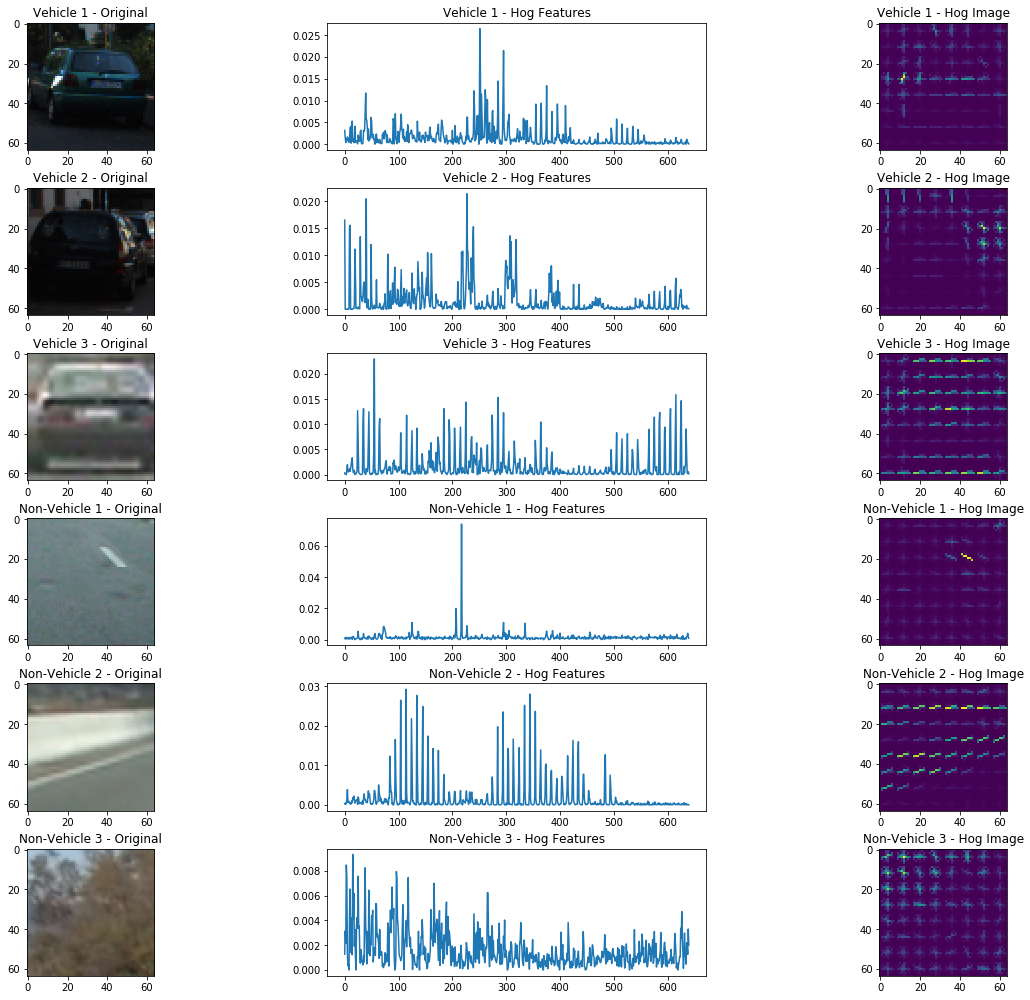

In [6]:
hog_list = []
fig,ax = plt.subplots(6,3,figsize=(18,14))
fig.tight_layout(pad=1.7)
ax = ax.ravel()
ax_i = 0
random_list = np.random.randint(0,len(vehicles),size=3)
for random_i in random_list:
    img = read_image(vehicles[random_i])
    img_ycrcb = cv2.cvtColor(img,cv2.COLOR_RGB2YCrCb)
    hog_feature,hog_img = hog_feature_extract(img_ycrcb[:,:,0],10,8,8,visualise=True,feature_vector=True)
    ax[ax_i].imshow(img)
    ax[ax_i].set_title('Vehicle ' + str(ax_i//3 + 1) + ' - Original')
    ax[ax_i+1].plot(hog_feature)
    ax[ax_i+1].set_title('Vehicle ' + str(ax_i//3 + 1) + ' - Hog Features')
    ax[ax_i+2].imshow(hog_img)
    ax[ax_i+2].set_title('Vehicle ' + str(ax_i//3 + 1) + ' - Hog Image')
    ax_i += 3

for random_i in random_list:
    img = read_image(non_vehicles[random_i])
    img_ycrcb = cv2.cvtColor(img,cv2.COLOR_RGB2YCrCb)
    hog_feature,hog_img = hog_feature_extract(img_ycrcb[:,:,0],10,8,8,visualise=True,feature_vector=True)
    ax[ax_i].imshow(img)
    ax[ax_i].set_title('Non-Vehicle ' + str(ax_i//3 + 1 - 3) + ' - Original')
    ax[ax_i+1].plot(hog_feature)
    ax[ax_i+1].set_title('Non-Vehicle ' + str(ax_i//3 + 1 - 3) + ' - Hog Features')
    ax[ax_i+2].imshow(hog_img)
    ax[ax_i+2].set_title('Non-Vehicle ' + str(ax_i//3 + 1 - 3) + ' - Hog Image')
    ax_i += 3

### Define Bin Spatial and Color Histogram Feature Functions
In addition, we define a bin spatial and color histogram functions to extract additional feature information from each of the images.

In [7]:
def bin_spatial_feature_extract(img,size=(32,32)):
    ch1= cv2.resize(img[:,:,0],size).ravel()
    ch2 = cv2.resize(img[:,:,1],size).ravel()
    ch3 = cv2.resize(img[:,:,2],size).ravel()
    return np.hstack((ch1,ch2,ch3))

def color_hist_feature_extract(img,n_bins=30):
    ch1_hist = np.histogram(img[:,:,0],bins=n_bins)
    ch2_hist = np.histogram(img[:,:,1],bins=n_bins)
    ch3_hist = np.histogram(img[:,:,2],bins=n_bins)
    return np.concatenate((ch1_hist[0],ch2_hist[0],ch3_hist[0]))

### Display Bin Spatial and Color Histogram Features for Sample Data 

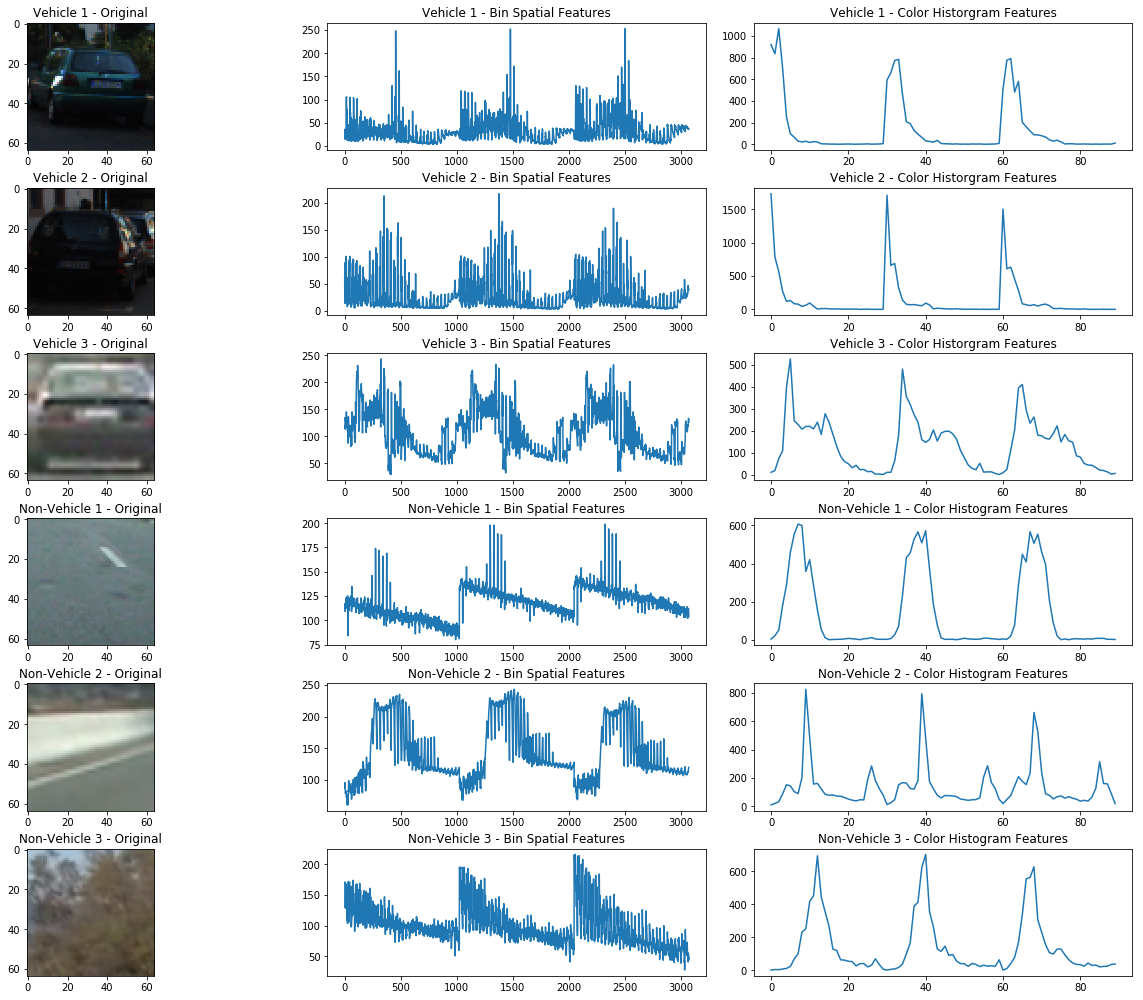

In [8]:
hog_list = []
fig,ax = plt.subplots(6,3,figsize=(18,14))
fig.tight_layout(pad=1.7)
ax = ax.ravel()
ax_i = 0

for random_i in random_list:
    img = read_image(vehicles[random_i])
    img_ycrcb = img
    img_bin_spatial = bin_spatial_feature_extract(img_ycrcb)
    img_color_hist = color_hist_feature_extract(img_ycrcb)
    ax[ax_i].imshow(img)
    ax[ax_i].set_title('Vehicle ' + str(ax_i//3 + 1) + ' - Original')
    ax[ax_i+1].plot(img_bin_spatial)
    ax[ax_i+1].set_title('Vehicle ' + str(ax_i//3 + 1) + ' - Bin Spatial Features')
    ax[ax_i+2].plot(img_color_hist)
    ax[ax_i+2].set_title('Vehicle ' + str(ax_i//3 + 1) + ' - Color Historgram Features')
    ax_i += 3

for random_i in random_list:
    img = read_image(non_vehicles[random_i])
    img_ycrcb = img
    img_bin_spatial = bin_spatial_feature_extract(img_ycrcb)
    img_color_hist = color_hist_feature_extract(img_ycrcb)
    ax[ax_i].imshow(img)
    ax[ax_i].set_title('Non-Vehicle ' + str(ax_i//3 + 1 - 3) + ' - Original')
    ax[ax_i+1].plot(img_bin_spatial)
    ax[ax_i+1].set_title('Non-Vehicle ' + str(ax_i//3 + 1 - 3) + ' - Bin Spatial Features')
    ax[ax_i+2].plot(img_color_hist)
    ax[ax_i+2].set_title('Non-Vehicle ' + str(ax_i//3 + 1 - 3) + ' - Color Histogram Features')
    ax_i += 3

### Extract All Features Function
Using this function we'll now combine the perviously defined feature extraction functions (hog, bin spatial, and color histogram features) to create a super feature for each image.

In [9]:
def extract_all_features(img_paths,color_space='YCrCb',spatial_size=(32,32),n_bins=30,orient=9,pix_per_cell=8,cell_per_block=2,hog_channel='ALL',spatial_bool=True,hist_bool=True,hog_bool=True):
    features = []
    for img_path in img_paths:
        file_features = []
        image = read_image(img_path)
        if color_space == 'RGB':
            feature_image = np.copy(image)
        elif color_space == 'HSV':
            feature_image = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(image,cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(image,cv2.COLOR_RGB2YUV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(image,cv2.COLOR_RGB2LUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(image,cv2.COLOR_RGB2YCrCb)
        
        if spatial_bool:
            spatial_features = bin_spatial_feature_extract(feature_image,size=spatial_size)
            file_features.append(spatial_features)
        if hist_bool:
            hist_features = color_hist_feature_extract(feature_image,n_bins=n_bins)
            file_features.append(hist_features)
        if hog_bool:
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(hog_feature_extract(feature_image[:,:,channel],orient,pix_per_cell,cell_per_block,visualise=False,feature_vector=True))
                hog_features = np.ravel(hog_features)
            else:
                hog_features = hog_feature_extract(feature_image[:,:,hog_channel],orient,pix_per_cell,cell_per_block,visualise=False,feature_vector=True)
            
            file_features.append(hog_features)
        
        features.append(np.concatenate(file_features))
        
    return features

### Extract Feature Data from Vehicle and Non-Vehicle Imageset
We define our X (inputs) using the extracted feature data from our vehicle/non-vehicle dataset. In addition, we also define our y labels (outputs) for both classes (vehicle = 1, non-vehicle = 0).

Note: If this is our first time training our classifier, the pickle_load parameter would be set to False.

In [10]:
if pickle_load == False:
    # extract features from images
    vehicle_features = extract_all_features(vehicles)
    non_vehicle_features = extract_all_features(non_vehicles,color_space='YCrCb',hog_channel='ALL')

    # create a single array with vehicle and non-vehicle feature data
    X = np.vstack((vehicle_features,non_vehicle_features))

    # define y label set
    y = np.concatenate((np.ones(len(vehicle_features)),np.zeros(len(non_vehicle_features))))

In [11]:
if pickle_load == False:
    mean_list = []
    for i in range(5):
        mean_list.append(np.mean(X[i]))
    print('Mean of X (first 5 examples):',np.round(mean_list,6))

### Normalize Data Features
The data features are normalized using sklearns StandardScaler() method.

In [12]:
if pickle_load == False:
    # create a StandardScaler() object
    scaler = StandardScaler()

    # fit object to X data -- this step calculates mean and std dev for each row of data
    X_scaled = scaler.fit(X)

    # use transform method to normalize data
    X_scaled = scaler.transform(X)

In [13]:
if pickle_load == False:
    mean_scaled_list = []
    for i in range(5):
        mean_scaled_list.append(np.mean(X_scaled[i]))
    print('Mean of Normalized X (first 5 examples):',np.round(mean_scaled_list,6))

### Split Training and Test Data
Our X features and y labels are split into training (80%) and test data (20%).

In [14]:
if pickle_load == False:
    X_train,X_test,y_train,y_test = train_test_split(X_scaled,y,test_size=0.2)
    print('Training features: X_count = {}, y_count = {}; Test Features: X_count = {}, y_count = {}'.format(len(X_train),len(y_train),len(X_test),len(y_test)))

### Train a Support Vector Classifier
Using our training data, we train a support vector classifier. Once training is complete, we verify that the classifier isn't overfit by cross checking our prediction accuracy score with the test data.

In [15]:
if pickle_load == False:
    svc = LinearSVC()
    t1 = time.time()
    svc.fit(X_train,y_train)
    t2 = time.time()
    print('Time to train classifier: {}s; Test Accuracy: {}'.format(round(t2-t1,4),round(svc.score(X_test,y_test),5)))

### Save Classifier using Pickle
Nice! Now that our classifier is properly trained, lets save it so we don't have spend time re-training in the future.

In [16]:
pickle_file = 'clf_and_data.p'
if pickle_load == False:
    clf_dict = {}
    clf_dict['svc'] = svc
    clf_dict['X'] = X
    clf_dict['X_scaled'] = X_scaled
    clf_dict['y'] = y
    pickle.dump(clf_dict,open(pickle_file,'wb'))
else:
    # load pickle data
    with open(pickle_file,'rb') as f:
        data = pickle.load(f)
    svc = data['svc']
#     X_scaled = data['X_scaled']
    X = data['X']
    y = data['y']
    
    # create a StandardScaler() object
    scaler = StandardScaler()

    # fit object to X data -- this step calculates mean and std dev for each row of data
    X_scaled = scaler.fit(X)

    # use transform method to normalize data
    X_scaled = scaler.transform(X)

### Searching for vehicles in an image
1. We first convert RGB images to YCrCb, as this is the color space we used to train our classifier with when we extracted our feature data. 
2. Then that image is cropped to the appropriate region of interest (essentially, where you'd expect other vehicles on the road to be). 
3. We resize the cropped image to be larger or smaller than its original size depending on the value provided by our scale parameter.
4. Next, we cycle through a number of possible search windows and retrieve its respecitve spatial, hog, and color histogram features.
5. Once we have the features collected, we can check to see if our classifier can find a positive vehicle match.
6. If a match is found, we append this window region to our 'on_windows' list.

In [17]:
def find_vehicles(img,y_start,y_stop,scale,svc,scaler,orient=9,pix_per_cell=8,cell_per_block=2,spatial_size=(32,32),n_bins=30,hog_channel='ALL',color_space='YCrCb',spatial_bool=True,hist_bool=True,hog_bool=True):
    img_convert = cv2.cvtColor(img,cv2.COLOR_RGB2YCrCb) # convert image to YCrCb
#     img_convert_normalized = img_convert.astype(np.float32)/255 # convert to float32 (since the original image is a uint8) and normalize image features
    img_cropped = img_convert[y_start:y_stop,:,:] # crop image
    
    # scale cropped image if scale isn't equal to 1
    if scale != 1:
        height,width = img_cropped.shape[:2]
        img_cropped = cv2.resize(img_cropped,(np.int(width/scale),np.int(height/scale)))
        
    ch1 = img_cropped[:,:,0]
    ch2 = img_cropped[:,:,1]
    ch3 = img_cropped[:,:,2]
    
    height,width = ch1.shape[:2]
    
    nx_blocks = np.int(width/pix_per_cell)+1
    ny_blocks = np.int(height/pix_per_cell)-1
    n_features_per_block = orient*cell_per_block**2
    
    window = 64
    n_blocks_per_window = np.int(window/pix_per_cell)-1
    cells_per_step = 2
    nx_steps = np.int((nx_blocks-n_blocks_per_window)/cells_per_step)
    ny_steps = np.int((ny_blocks-n_blocks_per_window)/cells_per_step)
    
    ch1_hog = hog_feature_extract(ch1,feature_vector=False)
    ch2_hog = hog_feature_extract(ch2,feature_vector=False)
    ch3_hog = hog_feature_extract(ch3,feature_vector=False)
    
    on_windows = []
    for x in range(nx_steps):
        for y in range(ny_steps):
            y_loc = y*cells_per_step
            x_loc = x*cells_per_step
                
            x_left = x_loc*pix_per_cell
            y_top = y_loc*pix_per_cell
            
            img_patch = cv2.resize(img_cropped[y_top:y_top+window,x_left:x_left+window], (64,64))
            
            # retrieve spatial features if enabled
            if spatial_bool:
                spatial_features = bin_spatial_feature_extract(img_patch,size=spatial_size)
                
            # retrieve histgoram features if enabled
            if hist_bool:
                hist_features = color_hist_feature_extract(img_patch,n_bins=n_bins)
            
            # retrieve hog features if enabled
            if hog_bool:
                if hog_channel == 0:
                    hog_features = ch1_hog[y_loc:y_loc+n_blocks_per_window,x_loc:x_loc+n_blocks_per_window].ravel()
                if hog_channel == 1:
                    hog_features = ch2_hog[y_loc:y_loc+n_blocks_per_window,x_loc:x_loc+n_blocks_per_window].ravel()
                if hog_channel == 2:
                    hog_features = ch3_hog[y_loc:y_loc+n_blocks_per_window,x_loc:x_loc+n_blocks_per_window].ravel()
                else:
                    hog_features1 =  ch1_hog[y_loc:y_loc+n_blocks_per_window,x_loc:x_loc+n_blocks_per_window].ravel()
                    hog_features2 =  ch2_hog[y_loc:y_loc+n_blocks_per_window,x_loc:x_loc+n_blocks_per_window].ravel()
                    hog_features3 =  ch3_hog[y_loc:y_loc+n_blocks_per_window,x_loc:x_loc+n_blocks_per_window].ravel()
                    hog_features = np.hstack((hog_features1,hog_features2,hog_features3))
            
            # combine all features into a single array
            X = np.hstack((spatial_features,hist_features,hog_features)).reshape(1,-1)
            
            test_features = scaler.transform(X)
            test_prediciton = svc.predict(test_features)
            
            # if prediction is true (or == 1), X is a vehicle; otherwise, it's a non-vehicle
            if test_prediciton:
                box_x_left = np.int(x_left*scale)
                box_y_top = np.int(y_top*scale)
                box_window = np.int(window*scale)

                on_windows.append(((box_x_left,box_y_top+y_start),(box_x_left+box_window,box_y_top+box_window+y_start)))
            
    return on_windows

### Image Scaling Function
This is used to run through a number of possible combinations of window scales, y_starts, and y_stops. Each possible combination is sent to the find_vehicles function, where we loop through all the possible windows with the provided parameters.

In [18]:
def scaled_detection(img,svc,scaler,search_window_scales=[1,1.5,2]):
    on_windows_list = []
    y_start_stop = [380, 720] # Min and max in y to search in slide_window()
    y_starts = [y_start_stop[0], y_start_stop[0], y_start_stop[0],y_start_stop[0]]
    y_stops = [y_start_stop[1]-150,y_start_stop[1]-75,y_start_stop[1],y_start_stop[1]]
#     search_window_scales = [0.9,1.3,1.6,2]  # (64x64), (96x96), (128x128)
#     search_window_scales = [0.9,1.3,1.7,2.1]  # (64x64), (96x96), (128x128)
#     search_window_scales = [1,1.5,2]  # (64x64), (96x96), (128x128)
    for search_window_scale,y_start,y_stop in zip(search_window_scales,y_starts,y_stops):
        on_windows_temp = find_vehicles(img,y_start,y_stop,search_window_scale,svc,scaler)
        on_windows_list.extend(on_windows_temp)
    return on_windows_list

### First Pass Bounding Boxes Function
The first pass bounding boxes are displayed.

In [19]:
def draw_bboxes_initial(img,bboxes,color=(0,0,255),thick=2):
    color_list = [(70,130,180),(0,0,255),(0,191,255),(240,255,255),(205,92,92),(221,160,221)]
    img_copy = np.copy(img)
    # img_copy_weighted = np.copy(img)
    for bbox in bboxes:
        color = color_list[np.random.randint(0,6)]
        cv2.rectangle(img_copy,bbox[0],bbox[1],color,thick)
        # img_copy_weighted = cv2.addWeighted(img,0.4,img_copy,0.6,0) # show bounding boxes with a 0.6 alpha
    return img_copy

### Heatmap Function
Using the on_windows discovered in the first pass, we develop a heatmap.

In [20]:
def generate_heatmap(img,windows_list):
    heatmap = np.zeros_like(img[:,:,0]).astype(np.uint8) # creates an array of zeros in the shape of the image
    
    # add heat to heatmap
    for window in windows_list:
        heatmap[window[0][1]:window[1][1],window[0][0]:window[1][0]] += 1
    
    # clip heatmap 
#     max_heat = 50 # limits the heat count in a region to 50
#     heatmap = np.clip(heatmap,0,max_heat)
    
    return heatmap

### Final Pass Bounding Boxes Function
This is a critical step in the process as aim to reduce the number of false positive vehicle matches. Three techniques are utilized to minimize the false positives in an image:
1. A heatmap buffer is used to track the previous 5 frames in a video. More recent frames have a higher weight (check the 'buffer_weights' variable).
2. Threshold is limited to 2, which means that any bounding box region that has only 2 or less frames will be considered a false positive match.
3. Finally, I employed a window size limit which ensures that the area of bounding boxes are significant. In this case, any bounding boxes that have a pixel area of less than 1500 are considered to be false positives.

In [21]:
def draw_bboxes_final(img,heatmap_view,heatmap_buffer,n_buffer=5,threshold_limit=2,window_size_limit=1500,color=(0,0,255),thick=3):
    img_bboxed = np.copy(img)
    
    heatmap_buffer.append(heatmap_view)
    
    # only retains info from the last 4 frames
    if len(heatmap_buffer) > n_buffer:
        heatmap_buffer.pop(0)
    
    # define buffer weights such that the more recent frames have a larger weight
    buffer_weights = np.arange(1,len(heatmap_buffer)+1)/sum(np.arange(1,len(heatmap_buffer)+1))
    
    # apply weights to heatmaps in memory
    for b,w,i in zip(heatmap_buffer,buffer_weights,range(n_buffer)):
        heatmap_buffer[i] = b*w
    
    # filter out any values that are less than or equal to the threshold limit
    heatmap = np.sum(np.array(heatmap_buffer),axis=0)
    heatmap[heatmap <= threshold_limit] = 0
    
    # label() method segregates each blob within the heatmap
    labels = label(heatmap)
    bboxes = []
    for detected_vehicle in range(1,labels[1]+1):
        non_zero = (labels[0] == detected_vehicle).nonzero()
        non_zero_y = np.array(non_zero[0])
        non_zero_x = np.array(non_zero[1])
        
        bbox_temp = ((np.min(non_zero_x),np.min(non_zero_y)),(np.max(non_zero_x),np.max(non_zero_y)))

        x1,y1 = bbox_temp[0][0],bbox_temp[0][1]
        x2,y2 = bbox_temp[1][0],bbox_temp[1][1]
        height = y2-y1
        width = x2-x1
        area = height*width

        # window size limit is used to minimize the number of (presumably small bounding box) false postive vehicle results
        if area > window_size_limit and height > 30 and width > 30:
            bboxes.append(bbox_temp)
            
    # draws the finalized bounding boxes onto the original image
    for i,bbox in enumerate(bboxes):
        cv2.rectangle(img_bboxed,bbox[0],bbox[1],(0,0,255),thick)
        
    return img_bboxed,heatmap,bboxes

### Vehicle Pipeline
This function defines our vehicle matching pipeline by combing our first/final pass bounding box and heatmap functions.

In [22]:
def vehicle_pipeline(img,svc,scaler,heatmap_buffer,n_buffer=5,threshold_limit=2,window_size_limit=1500,search_window_scales=[1,1.5],heat=False):
    windows_initial = scaled_detection(img,svc,scaler,search_window_scales)
    heatmap_initial = generate_heatmap(img,windows_initial)
#     heatmap_buffer.append(heatmap)
    
    img_bboxed,heatmap_final,bboxes = draw_bboxes_final(img,heatmap_initial,heatmap_buffer,n_buffer,threshold_limit,window_size_limit)
    if heat:
        return img_bboxed,bboxes,heatmap_initial,heatmap_final
    else:
        return img_bboxed,bboxes

### Test Image: First Pass Bounding Boxes
We test our first pass bounding box function with a test image. It appears to perform relatively well, although the classifier did pick up a positive vehicle match on the opposing direction of traffic.

C:\Users\Selim\Anaconda3\envs\tfenv\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


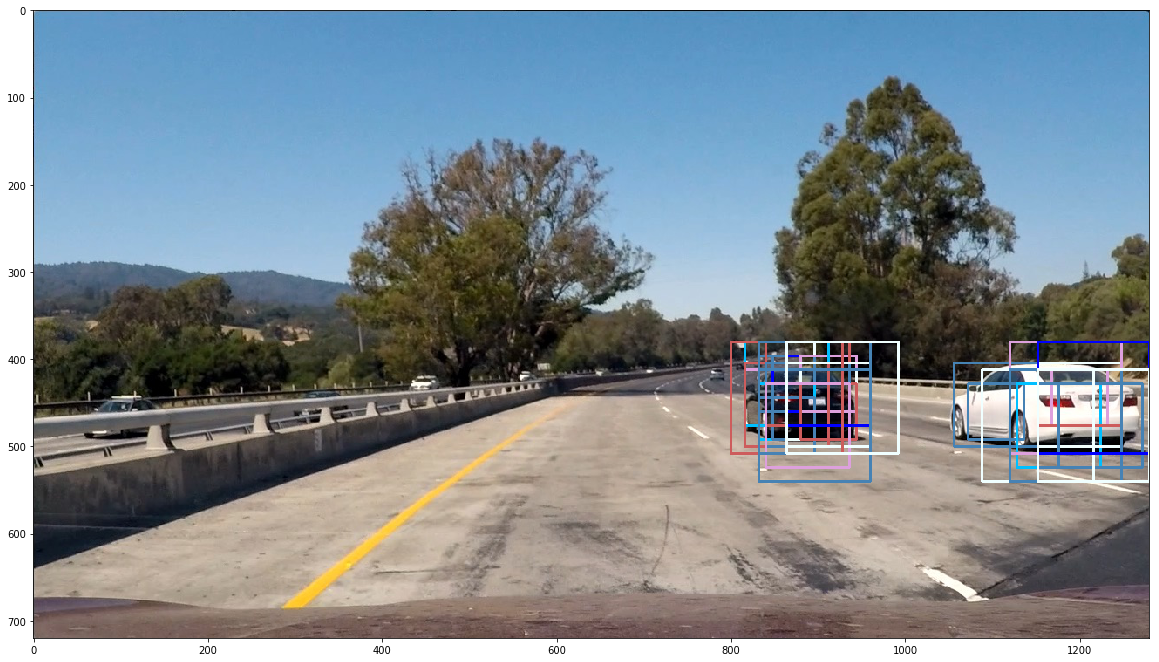

In [23]:
test_img = read_image('./test_images/test1.jpg')
on_windows_list = scaled_detection(test_img,svc,scaler,search_window_scales=[1,1.5,2])
test_img_bboxes = draw_bboxes_initial(test_img,on_windows_list)
plt.figure(figsize=(20,20))
plt.imshow(test_img_bboxes)

### Test Image: First Pass Heatmap
The brighter the region, the more confident our classifier is that it has a positive vehicle match.

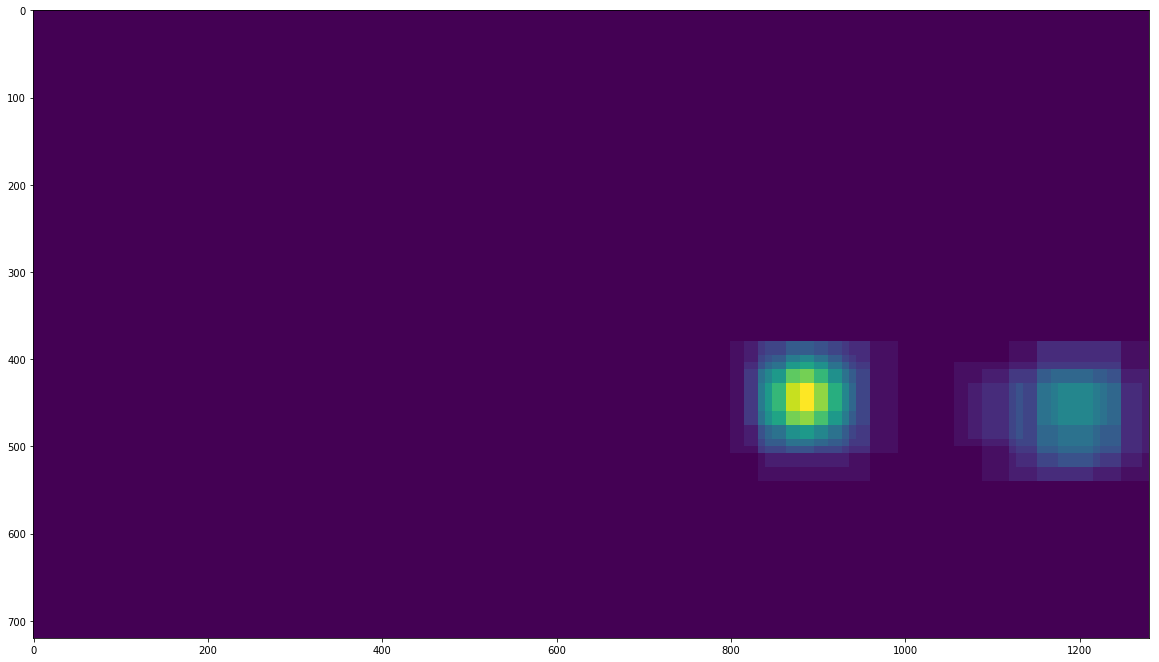

In [24]:
test_img_heatmap = generate_heatmap(test_img,on_windows_list)
plt.figure(figsize=(20,20))
plt.imshow(test_img_heatmap)

### Test Image: Finalized Bounding Boxes

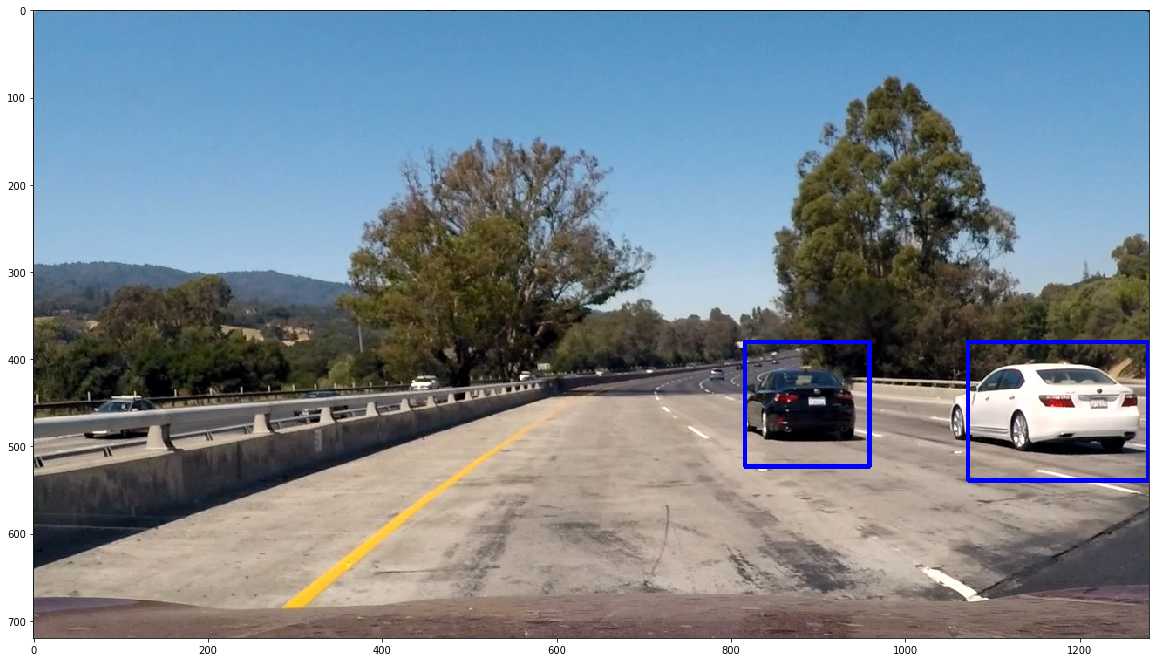

In [25]:
heatmap_buffer = []
test_img_bboxed,test_img_heatmap_final,test_img_bboxes = draw_bboxes_final(test_img,test_img_heatmap,heatmap_buffer,n_buffer=2,threshold_limit=1)
plt.figure(figsize=(20,20))
plt.imshow(test_img_bboxed)

### Test Vehicle Detection Pipeline in Problematic Areas
Now let's test to see how our vehicle tracking pipeline performs in a number of problem areas in the project video. I used this step to fine tune my parameters before running it on the project video. 

The first image is shows the first pass heatmap, the second image shows the final heatmap, and the third image shows our finalized bounding box.

C:\Users\Selim\Anaconda3\envs\tfenv\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


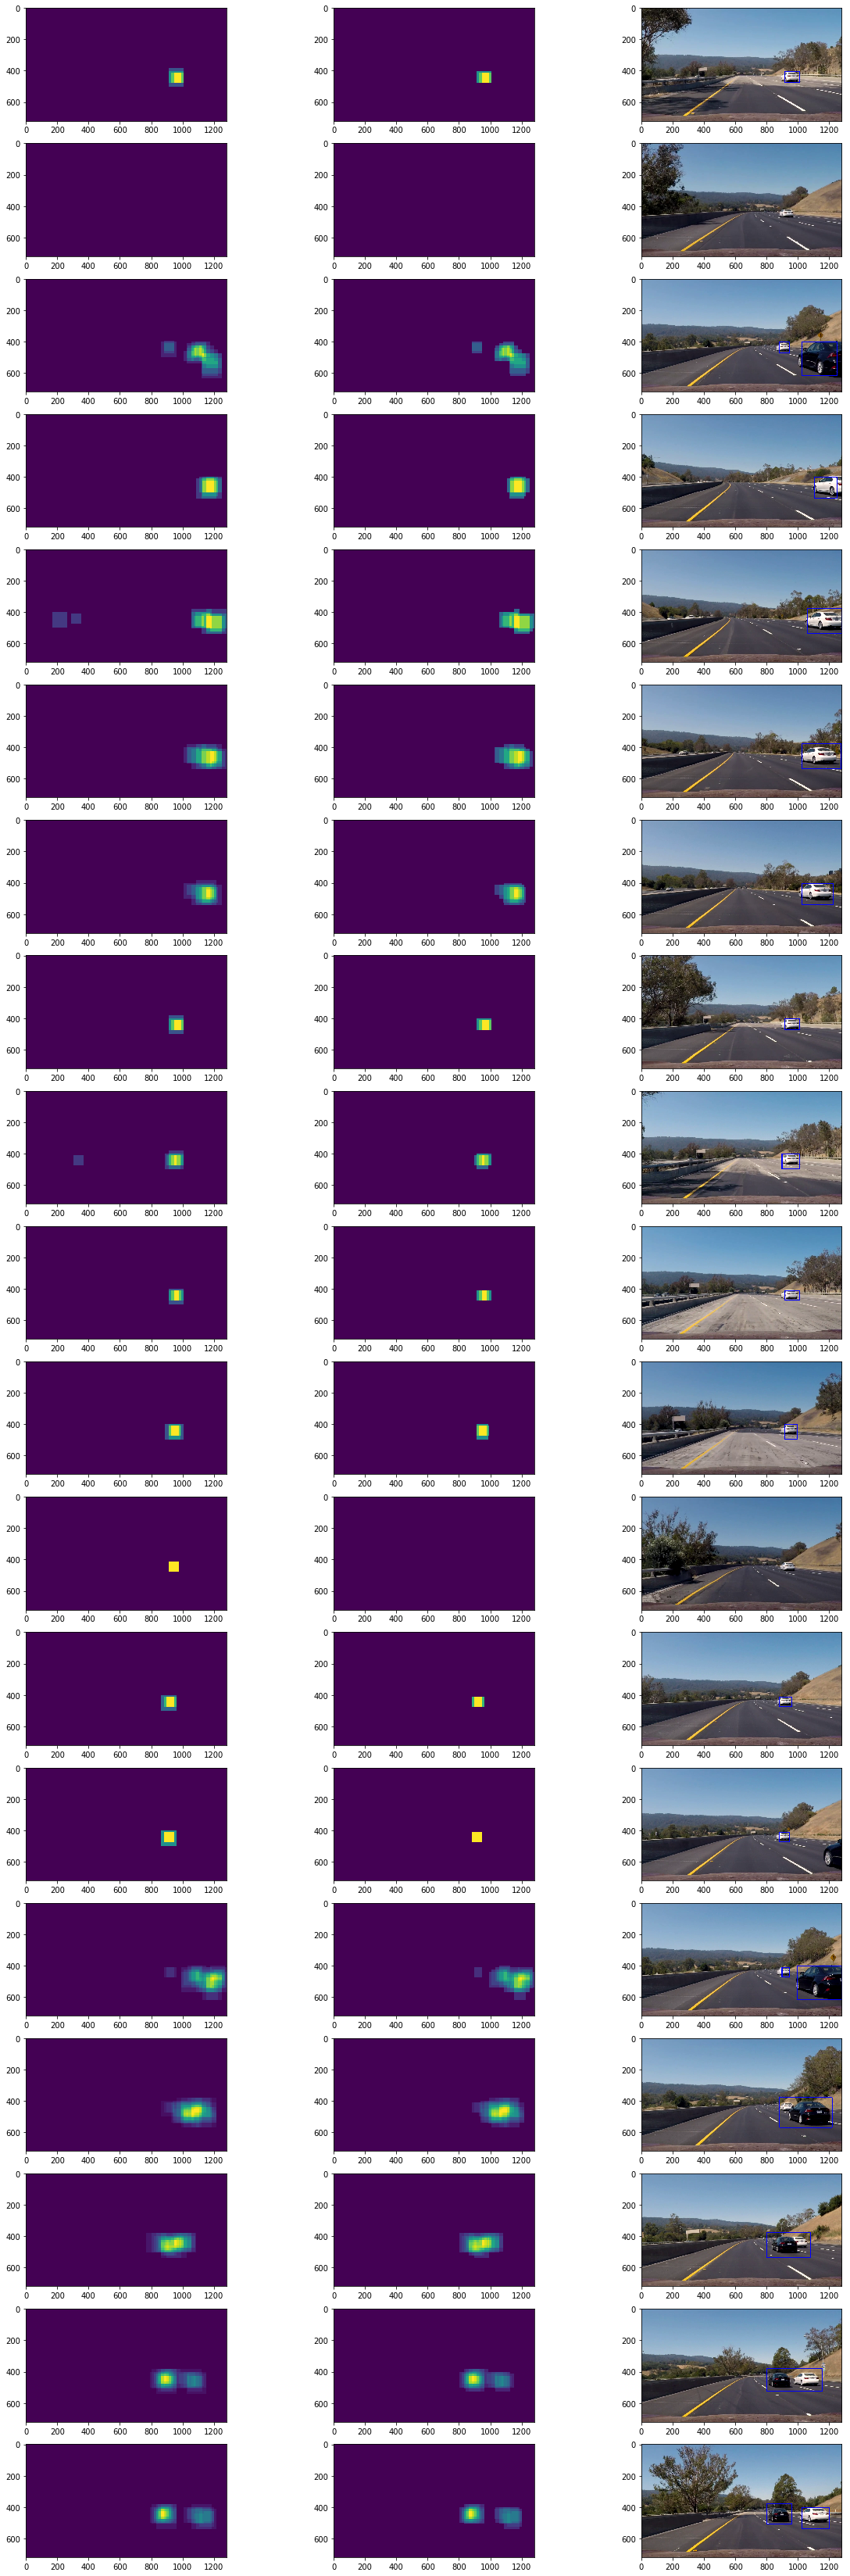

In [26]:
heatmap_buffer = []
selims_test_images = glob.glob('./selims_test_images/*.png')
fig,ax = plt.subplots(19,3,figsize=(20,60))
# ax = ax.ravel()
for i,image_path in enumerate(selims_test_images):
    img = read_image(image_path) # read_image method returns an image of uint8 dtype
    img_vehicle_bboxed,img_vehicle_bboxes,img_heat_initial,img_heat_final = vehicle_pipeline(img,svc,scaler,heatmap_buffer,n_buffer=1,threshold_limit=1,window_size_limit=1500,search_window_scales=[1,1.5,2],heat=True)
    ax[i,0].imshow(img_heat_initial)
    ax[i,1].imshow(img_heat_final)
    ax[i,2].imshow(img_vehicle_bboxed)

# Model Performance
Our model peformed considerably well. On a few occasions, the model picks up vehicles from the opposing lane of traffic and there's also some areas of the video where the bounding boxes aren't properly displayed. These issues are most likely related to the lack of image scaling at various other sizes, since the classifier is looking for images within the 1.0, 1.5, 2.0 image factor sizes.

<a href='https://www.youtube.com/watch?v=MsPSgDkyGIk'>![Project Video Output](project_video_out.gif)</a>

# Future Work
Some room for potential improvement:
1. Modify the training dataset by incorporating slightly augmented images (modified image brightness, skew and rotation) to see if the classifier is able to generalize better, and ultimately, provide more accurate true positive matches.
2. It might be interesting to see how well my tracking pipeline performs on my own footage of driving on the freeway.
3. Explore ways to make the window scaling system more efficient so that images are processed as close to real-time as possible.
4. Lastly, it might be worthwhile to test other available sklearn classifiers and even a convolution neural network.